# **COS30082 - ML Project: Cross-domain Plant Species Identification**

## **Baseline 2: Leveraging a Plant-Pretrained Model (DINOv2) with a Random Forest Classifier**

This notebook implements the second baseline approach. It uses a pre-trained DINOv2 model as a feature extractor and then trains a Random Forest classifier on those features.

The process involves:
1. Setting up a persistent cache on Google Drive to store the model.
2. Loading the pre-trained DINOv2 model.
3. Extracting deep feature embeddings from the plant images.
4. Training a Random Forest classifier on the extracted features.
5. Evaluating the classifier's performance using top-1 and top-5 accuracy.

# **1.0 Install Necessary Packages**

In [ ]:
# This cell installs all the required libraries for the project.
# The '-q' flag makes the output less verbose.
!pip install kagglehub torch torchvision scikit-learn pandas numpy Pillow tqdm matplotlib -q

# **2.0 Import Libraries**

In [ ]:
# For Google Colab to access Google Drive
from google.colab import drive

# General purpose libraries
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import random
import gc

# Visualization
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch libraries
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Scikit-learn and Kaggle Hub
from sklearn.metrics import accuracy_score, top_k_accuracy_score
import kagglehub
from sklearn.ensemble import RandomForestClassifier # Back to the original!

# **3.0 Mount Google Drive and Set Up Persistent Kaggle Cache**

In [ ]:
# --- 1. Mount Google Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully.")

Mounting Google Drive...
Mounted at /content/drive
Drive mounted successfully.


In [ ]:
# --- 2. Define a persistent path in Drive for the model cache ---
# This ensures the model is downloaded only once and is saved for future sessions.
project_dir = '/content/drive/My Drive/Colab Notebooks/COS30082_ML_Project'
cache_dir = os.path.join(project_dir, 'kaggle_cache')
os.makedirs(cache_dir, exist_ok=True) # Create the directory if it doesn't exist

In [ ]:
# --- 3. Set the KAGGLE_CACHE environment variable ---
# This tells kagglehub to use the specified Drive folder instead of a temporary one.
os.environ['KAGGLE_CACHE'] = cache_dir
print(f"Kaggle cache path set to: {os.environ['KAGGLE_CACHE']}")

Kaggle cache path set to: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/kaggle_cache


# **4.0 Define Data Paths and Helper Functions**

In [ ]:
# --- IMPORTANT: SET THIS PATH TO YOUR DATASET'S LOCATION ---
DATA_DIR = os.path.join(project_dir, 'AML_dataset')

# Helper function to read image paths and labels from the provided text files
def load_data_from_files(data_dir, list_file):
    file_path = os.path.join(data_dir, 'list', list_file)
    with open(file_path, 'r') as f:
        lines = f.readlines()

    image_paths = []
    labels = []
    for line in lines:
        parts = line.strip().split()
        if not parts: continue # Skip empty lines
        image_paths.append(os.path.join(data_dir, parts[0]))
        if len(parts) > 1:
            labels.append(int(parts[1]))

    return image_paths, labels if labels else None

# A more robust function to load the species map
def load_species_map(data_dir):
    species_map = {}
    file_path = os.path.join(data_dir, 'list', 'species_list.txt')
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f):
            parts = line.strip().split()
            if not parts: continue # Skip empty lines

            try:
                # The class ID is the FIRST part of the line.
                class_id_str = parts[0].strip(';,')

                # --- ROBUST FIX ---
                # Ensure the key we store in the dictionary is an INTEGER.
                class_id = int(class_id_str)

                species_name = " ".join(parts[1:])
                species_map[class_id] = species_name
            except (ValueError, IndexError):
                print(f"Warning: Skipping malformed line {line_num + 1} in species_list.txt: '{line.strip()}'")
                continue

    # --- DEBUGGING STEP ---
    # Print a sample from the dictionary to confirm it's correct
    print("Successfully loaded species map. Sample entry:")
    sample_key = next(iter(species_map))
    print(f"  Key: {sample_key} (Type: {type(sample_key)}), Value: '{species_map[sample_key]}'")

    return species_map

# Load training data paths and labels
train_image_paths, train_labels = load_data_from_files(DATA_DIR, 'train.txt')
# Load species map
species_id_to_name = load_species_map(DATA_DIR)

print(f"Found {len(train_image_paths)} training images.")
print(f"Found {len(species_id_to_name)} unique species.")

Successfully loaded species map. Sample entry:
  Key: 105951 (Type: <class 'int'>), Value: 'Maripa glabra Choisy'
Found 4744 training images.
Found 100 unique species.


# **5.0 Exploratory Data Analysis and Visualization**

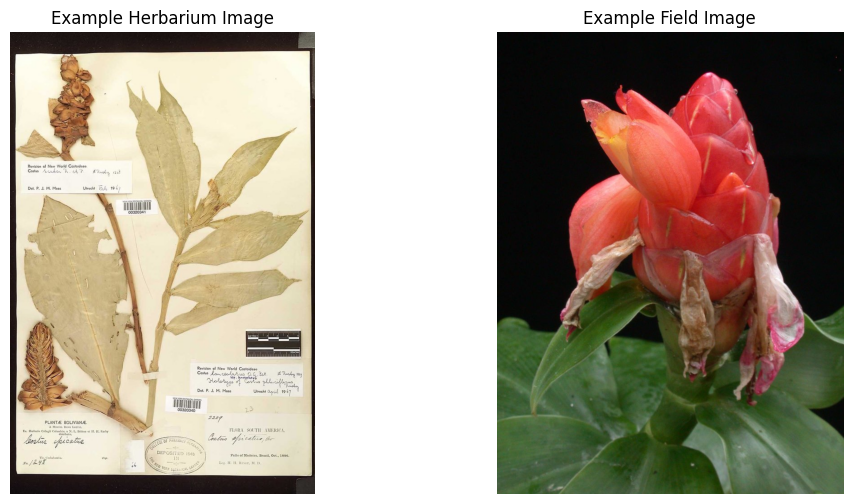

In [ ]:
# --- Visualization 1: Display Sample Herbarium and Field Images ---

try:
    # Find a herbarium image (often contains 'herbier' or is a scan)
    herbarium_path = next(p for p in train_image_paths if 'herbarium' in p)
    field_photo_path = next(p for p in train_image_paths if 'photo' in p)

    herbarium_img = Image.open(herbarium_path)
    field_img = Image.open(field_photo_path)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(herbarium_img)
    axs[0].set_title('Example Herbarium Image')
    axs[0].axis('off')

    axs[1].imshow(field_img)
    axs[1].set_title('Example Field Image')
    axs[1].axis('off')
    plt.show()

except StopIteration:
    print("Could not automatically find example images. Please specify paths manually.")

In [ ]:
# --- Visualization 2: List Species without Herbarium-Field Pairs ---
print("--- Species with Herbarium Samples Only (No Field Photos in Training) ---")
with open(os.path.join(DATA_DIR, 'list', 'class_without_pairs.txt'), 'r') as f:
    herbarium_only_ids = {int(line.strip()) for line in f}

for class_id in sorted(list(herbarium_only_ids)):
    print(f"ID: {class_id}, Name: {species_id_to_name.get(class_id, 'Unknown')}")

--- Species with Herbarium Samples Only (No Field Photos in Training) ---
ID: 12254, Name: Anacardium occidentale L.
ID: 13276, Name: Annona ambotay Aubl.
ID: 13325, Name: Annona foetida Mart.
ID: 14401, Name: Guatteria scandens Ducke
ID: 15014, Name: Rollinia mucosa (Jacq.) Baill.
ID: 15330, Name: Xylopia cayennensis Maas
ID: 105951, Name: Maripa glabra Choisy
ID: 106387, Name: Costus arabicus L.
ID: 106466, Name: Costus spiralis (Jacq.) Roscoe
ID: 116853, Name: Pteridium arachnoideum (Kaulf.) Maxon
ID: 119986, Name: Olfersia cervina (L.) Kunze
ID: 120497, Name: Diospyros capreifolia Mart. ex Hiern
ID: 121841, Name: Sloanea guianensis (Aubl.) Benth.
ID: 125412, Name: Sphyrospermum cordifolium Benth.
ID: 126895, Name: Syngonanthus caulescens (Poir.) Ruhland
ID: 127007, Name: Tonina fluviatilis Aubl.
ID: 127242, Name: Erythroxylum squamatum Sw.
ID: 130657, Name: Euphorbia cotinifolia L.
ID: 132113, Name: Euphorbia tithymaloides L.
ID: 132501, Name: Jatropha gossypiifolia L.
ID: 136761, 

# **6.0 Visualize Image Transformations**

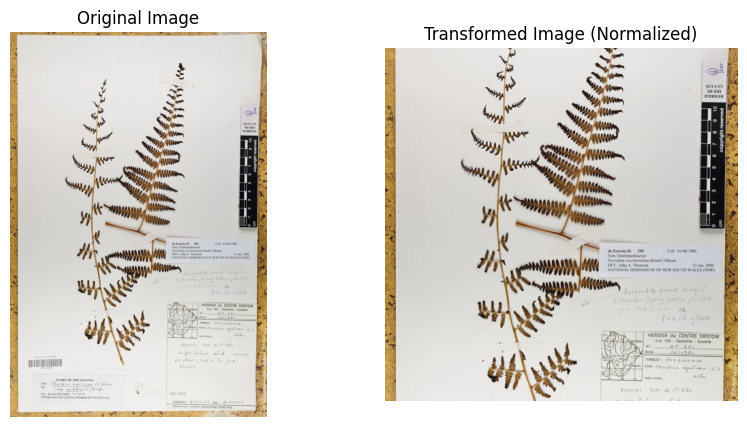

In [ ]:
# Define the transformations
# CRUCIAL FIX: The input size must match the size the DINOv2 model was fine-tuned on (518x518).
transform = transforms.Compose([
    transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to un-normalize and display a tensor image
def imshow_tensor(tensor, title=None):
    # Clone the tensor so we don't modify the original
    image = tensor.clone().cpu()
    # Define the inverse normalization
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    # Reshape mean and std to be broadcastable
    image = image * std[:, None, None] + mean[:, None, None]
    # Reorder dimensions from (C, H, W) to (H, W, C) for matplotlib
    image = image.permute(1, 2, 0)
    # Clip values to be in the [0, 1] range for valid display
    image = torch.clip(image, 0, 1)

    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

# Load a random training image
random_image_path = random.choice(train_image_paths)
original_img = Image.open(random_image_path).convert("RGB")
transformed_img_tensor = transform(original_img)

# Display side-by-side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
imshow_tensor(transformed_img_tensor, "Transformed Image (Normalized)")
plt.show()

# **7.0 Download and Load the Pre-trained DINOv2 Model**

In [ ]:
# Import the timm library, which is a huge collection of PyTorch image models
!pip install timm -q
import timm

In [ ]:
# --- Step 1: Download the model files from Kaggle ---
print("Downloading/Locating model files from Kaggle Hub...")
path_to_model_files = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default")
print("Path to model directory:", path_to_model_files)

# List the actual files in the downloaded directory for confirmation
downloaded_files = os.listdir(path_to_model_files)
print("\nFiles found in the directory:", downloaded_files)

Downloading/Locating model files from Kaggle Hub...



100%|██████████| 9.79k/9.79k [00:00<00:00, 19.6MB/s]



100%|██████████| 2.86k/2.86k [00:00<00:00, 7.59MB/s]



  0%|          | 0.00/1.38G [00:00<?, ?B/s]
  0%|          | 1.00M/1.38G [00:01<31:21, 787kB/s]
  0%|          | 2.00M/1.38G [00:01<16:05, 1.53MB/s]
  0%|          | 3.00M/1.38G [00:01<10:09, 2.43MB/s]
  0%|          | 5.00M/1.38G [00:01<05:30, 4.46MB/s]
  0%|          | 7.00M/1.38G [00:01<03:35, 6.83MB/s]
  1%|          | 9.00M/1.38G [00:02<02:46, 8.86MB/s]
  1%|          | 11.0M/1.38G [00:02<02:14, 10.9MB/s]
  1%|          | 13.0M/1.38G [00:02<01:59, 12.3MB/s]
  1%|          | 15.0M/1.38G [00:02<01:44, 14.1MB/s]
  1%|          | 17.0M/1.38G [00:02<02:19, 10.5MB/s]
  1%|▏         | 21.0M/1.38G [00:02<01:49, 13.3MB/s]
  2%|▏         | 23.0M/1.38G [00:03<02:03, 11.8MB/s]
  2%|▏         | 26.0M/1.38G [00:03<01:56, 12.5MB/s]
  2%|▏         | 29.0M/1.38G [00:03<01:49, 13.3MB/s]
  2%|▏         | 32.0M/1.38G [00:03<01:52, 12.9MB/s]
  3%|▎         | 36.0M/1.38G [00:04<01:40, 14.4MB/s]
  3%|▎         | 39.0M/1.38G [00:04<01:37, 14.8MB/s]
  3%|▎         | 43.0M/1.38G [00:04<01:29, 16.0MB/s]
 

Path to model directory: /root/.cache/kagglehub/models/juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default/3

Files found in the directory: ['summary.csv', 'model_best.pth.tar', 'args.yaml']


In [ ]:
# --- Step 2: Build the correct model architecture using timm ---
timm_model_name = 'vit_base_patch14_reg4_dinov2.lvd142m'
try:
    print(f"\nBuilding the '{timm_model_name}' architecture using the timm library...")
    dinov2_model = timm.create_model(timm_model_name, pretrained=False)

    # IMPORTANT: Remove the classifier head BEFORE loading the weights.
    # This prepares our model to be a feature extractor.
    dinov2_model.reset_classifier(0, '')
    print("Model architecture created and classifier head removed.")
except Exception as e:
    print(f"!!! FATAL ERROR: Could not build the timm model architecture. Error: {e}")
    dinov2_model = None
    raise


Building the 'vit_base_patch14_reg4_dinov2.lvd142m' architecture using the timm library...
Model architecture created and classifier head removed.


In [ ]:
# --- Step 3: Find and Load the downloaded fine-tuned weights ---
if dinov2_model is not None:
    try:
        # Find the weights file
        weights_filename = next((f for f in downloaded_files if f.endswith(('.pth', '.pt', '.tar'))), None)
        if weights_filename is None:
            raise FileNotFoundError("Could not find a weights file.")

        weights_path = os.path.join(path_to_model_files, weights_filename)
        print(f"\nFound weights file. Loading from: {weights_path}")

        # 1. Load the checkpoint
        # FIX 1: Added weights_only=False to resolve the PyTorch 2.6 security error
        checkpoint = torch.load(weights_path, map_location='cpu', weights_only=False)

        # 2. Extract the state dictionary
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint

        # 3. FIX 2: Strip the "module." prefix so weights actually load into the backbone
        new_state_dict = {}
        for k, v in state_dict.items():
            # If the key starts with "module.", remove it
            name = k.replace("module.", "")
            new_state_dict[name] = v

        # 4. Load the fixed dictionary
        # strict=False allows us to ignore the old classifier head
        missing_keys, unexpected_keys = dinov2_model.load_state_dict(new_state_dict, strict=False)

        # 5. Verify Success
        print(f"\n--- Weight Loading Report ---")
        print(f"Unexpected keys (should be close to 0): {len(unexpected_keys)}")
        # If successful, missing_keys will only contain 'head.weight', 'head.bias' etc.
        print(f"Missing keys (should be small, mostly 'head' layers): {len(missing_keys)}")

        if len(missing_keys) > 0:
            print(f"Sample missing keys: {missing_keys[:3]}")

        print("\nSuccessfully loaded fine-tuned weights into the model backbone.")

    except Exception as e:
        print(f"!!! FATAL ERROR: Could not load the fine-tuned weights. Error: {e}")
        dinov2_model = None
        raise


Found weights file. Loading from: /root/.cache/kagglehub/models/juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default/3/model_best.pth.tar

--- Weight Loading Report ---
Unexpected keys (should be close to 0): 2
Missing keys (should be small, mostly 'head' layers): 0

Successfully loaded fine-tuned weights into the model backbone.


In [ ]:
# --- Step 4: Prepare the model for inference ---
if dinov2_model:
    dinov2_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dinov2_model.to(device)
    print(f"\nModel is ready and has been moved to {device}.")


Model is ready and has been moved to cuda.


# **8.0 Define Data Transformations and Custom Dataset**

In [ ]:
# This cell uses the paths loaded earlier to create PyTorch Datasets and DataLoaders.

# Define the custom Dataset class
class PlantDataset(Dataset):
    def __init__(self, image_paths, labels=None, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            return image, self.labels[idx]
        else:
            return image

# Load test data paths and ground truth labels
test_image_paths, _ = load_data_from_files(DATA_DIR, 'test.txt')
_, test_labels = load_data_from_files(DATA_DIR, 'groundtruth.txt')

# Create Datasets and DataLoaders
train_dataset = PlantDataset(train_image_paths, labels=train_labels, transform=transform)
test_dataset = PlantDataset(test_image_paths, labels=test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"\nCreated DataLoaders for {len(train_dataset)} training and {len(test_dataset)} test images.")


Created DataLoaders for 4744 training and 207 test images.


# **9.0 Define and Run Feature Extraction**

In [ ]:
def extract_features_sequential(image_paths, model, transform, device, batch_size=32):
    """
    Extracts features using DINOv2 with safety checks.
    """
    model.eval()
    features_list = []

    # --- CRITICAL FIX: Initialize failure_count here ---
    failure_count = 0

    # Loop through the list in batches
    total_images = len(image_paths)

    for i in tqdm(range(0, total_images, batch_size), desc="Extracting Features"):
        batch_paths = image_paths[i : i + batch_size]
        batch_tensors = []

        for img_path in batch_paths:
            try:
                # Ensure path exists
                if not os.path.exists(img_path):
                    # Try fixing path if needed (sometimes dataset unzips oddly)
                    raise FileNotFoundError(f"File not found: {img_path}")

                img = Image.open(img_path).convert("RGB")
                img_tensor = transform(img)
                batch_tensors.append(img_tensor)

            except Exception as e:
                # Count the failure but don't crash
                failure_count += 1
                # Add a placeholder (Zeros) to keep array shape consistent
                batch_tensors.append(torch.zeros(3, 518, 518))

        if not batch_tensors:
            continue

        # Stack into a single batch tensor
        batch_input = torch.stack(batch_tensors).to(device)

        with torch.no_grad():
            outputs = model(batch_input)
            # Select [CLS] token (Index 0)
            batch_features = outputs[:, 0, :].cpu().numpy()

        features_list.append(batch_features)

    # --- Reporting ---
    if failure_count > 0:
        print(f"\n⚠️ WARNING: {failure_count} images failed to load!")
        print("Check your DATA_DIR path. Training on zeros will hurt performance.")
    else:
        print("\n✅ All images loaded successfully.")

    # Stack all batches into one large numpy array
    return np.vstack(features_list)

In [ ]:
# --- RUN EXTRACTION ---

print("--- 1. Extracting Training Features ---")
# Ensure DATA_DIR is correct
print(f"Reading images from: {DATA_DIR}")

# Run Extraction
X_train = extract_features_sequential(train_image_paths, dinov2_model, transform, device)
y_train = np.array(train_labels)

print(f"Training Features Shape: {X_train.shape}")

print("\n--- 2. Extracting Test Features ---")
X_test = extract_features_sequential(test_image_paths, dinov2_model, transform, device)
y_test = np.array(test_labels)

print(f"Test Features Shape: {X_test.shape}")

# --- SANITY CHECK ---
if np.mean(np.abs(X_train)) < 1e-6:
    print("\n❌ CRITICAL ERROR: Features are all zeros! Check input images.")
else:
    print("✅ Features look valid. Proceeding to training.")

--- 1. Extracting Training Features ---
Reading images from: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/AML_dataset


Extracting Features: 100%|██████████| 149/149 [1:41:06<00:00, 40.72s/it]



✅ All images loaded successfully.
Training Features Shape: (4744, 768)

--- 2. Extracting Test Features ---


Extracting Features: 100%|██████████| 7/7 [04:23<00:00, 37.61s/it]


✅ All images loaded successfully.
Test Features Shape: (207, 768)
✅ Features look valid. Proceeding to training.


# **10.0 Train the Random Forest Classifier**

In [ ]:
# Initialize and Train
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=1)

print("\nTraining Random Forest Classifier on aligned data...")
rf_classifier.fit(X_train, y_train)
print("Training Complete.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.



Training Random Forest Classifier on aligned data...


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.6s


Training Complete.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.2s finished


# **11.0 Main Evaluation on Entire Test Set**

In [ ]:
print("\n--- Generating Predictions ---")
# Get class probabilities (needed for Top-5)
y_pred_proba = rf_classifier.predict_proba(X_test)
# Get Top-1 predictions
y_pred_top1 = rf_classifier.predict(X_test)

# --- Metric 1: Overall Performance ---
overall_top1 = accuracy_score(y_test, y_pred_top1)
overall_top5 = top_k_accuracy_score(y_test, y_pred_proba, k=5, labels=rf_classifier.classes_)

print(f"\n=== Overall Results ({len(y_test)} images) ===")
print(f"Top-1 Accuracy: {overall_top1 * 100:.2f}%")
print(f"Top-5 Accuracy: {overall_top5 * 100:.2f}%")

# --- Metric 2: Sub-group Performance ---

# Load the "Herbarium Only" class IDs
class_without_pairs_path = os.path.join(DATA_DIR, 'list', 'class_without_pairs.txt')
with open(class_without_pairs_path, 'r') as f:
    herbarium_only_ids = set(int(line.strip()) for line in f)

# Create boolean masks to split the TEST data
is_herbarium_only = np.isin(y_test, list(herbarium_only_ids))
is_with_pairs = ~is_herbarium_only

# --- A. With-Pairs Evaluation (Seen Herbarium + Field Photo) ---
y_test_pairs = y_test[is_with_pairs]
y_proba_pairs = y_pred_proba[is_with_pairs]
y_pred_pairs = y_pred_top1[is_with_pairs]

print(f"\n=== 'With-Pairs' Species ({len(y_test_pairs)} images) ===")
if len(y_test_pairs) > 0:
    acc_top1_pairs = accuracy_score(y_test_pairs, y_pred_pairs)
    acc_top5_pairs = top_k_accuracy_score(y_test_pairs, y_proba_pairs, k=5, labels=rf_classifier.classes_)
    print(f"Top-1 Accuracy: {acc_top1_pairs * 100:.2f}%")
    print(f"Top-5 Accuracy: {acc_top5_pairs * 100:.2f}%")
else:
    print("No samples found.")

# --- B. Herbarium-Only Evaluation (The Hard Case) ---
y_test_herb = y_test[is_herbarium_only]
y_proba_herb = y_pred_proba[is_herbarium_only]
y_pred_herb = y_pred_top1[is_herbarium_only]

print(f"\n=== 'Herbarium-Only' Species ({len(y_test_herb)} images) ===")
if len(y_test_herb) > 0:
    acc_top1_herb = accuracy_score(y_test_herb, y_pred_herb)
    acc_top5_herb = top_k_accuracy_score(y_test_herb, y_proba_herb, k=5, labels=rf_classifier.classes_)
    print(f"Top-1 Accuracy: {acc_top1_herb * 100:.2f}%")
    print(f"Top-5 Accuracy: {acc_top5_herb * 100:.2f}%")
else:
    print("No samples found.")


--- Generating Predictions ---

=== Overall Results (207 images) ===
Top-1 Accuracy: 65.22%
Top-5 Accuracy: 72.95%

=== 'With-Pairs' Species (153 images) ===
Top-1 Accuracy: 87.58%
Top-5 Accuracy: 95.42%

=== 'Herbarium-Only' Species (54 images) ===
Top-1 Accuracy: 1.85%
Top-5 Accuracy: 9.26%


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


# **12.0 Save the model**

In [ ]:
import joblib
# Save the model to your Drive for future use
model_save_path = os.path.join(project_dir, 'rf_classifier_dinov2_aligned.joblib')
joblib.dump(rf_classifier, model_save_path)
print(f"\nModel saved to: {model_save_path}")


Model saved to: /content/drive/My Drive/Colab Notebooks/COS30082_ML_Project/rf_classifier_dinov2_aligned.joblib


# **13.0 Visualizing Predictions on Test Set**

In [ ]:
# --- 1. Reload Essential Models and Data ---

# Check if models and data are already in memory, otherwise load them.
# This makes the cell runnable on its own after a kernel restart.

print("--- Step 1: Loading all necessary components ---")

# a) Load the saved RF Classifier
model_filename = 'rf_classifier_dinov2.joblib'
model_save_path = os.path.join(project_dir, model_filename)

if 'rf_classifier' not in locals():
    print(f"Loading RF classifier from: {model_save_path}")
    try:
        rf_classifier = joblib.load(model_save_path)
        print("RF Classifier loaded successfully.")
    except FileNotFoundError:
        print(f"!!! ERROR: Model file not found at {model_save_path}. Please run the training and saving cell first.")
        # Stop execution if the model isn't there
        raise

# b) Ensure DINOv2 model is loaded and on the correct device
if 'dinov2_model' not in locals() or dinov2_model is None:
    print("DINOv2 model not found in memory, attempting to reload...")
    # This block is a condensed version of Cell 7 to reload the model
    # It assumes the files have already been downloaded to the cache
    path_to_model_files = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default")
    timm_model_name = 'vit_base_patch14_reg4_dinov2.lvd142m'
    dinov2_model = timm.create_model(timm_model_name, pretrained=False)
    dinov2_model.reset_classifier(0, '')
    weights_filename = next((f for f in os.listdir(path_to_model_files) if f.endswith(('.pth', '.pt', '.tar'))), None)
    weights_path = os.path.join(path_to_model_files, weights_filename)
    checkpoint = torch.load(weights_path, map_location='cpu')
    state_dict = checkpoint.get('state_dict', checkpoint)
    dinov2_model.load_state_dict(state_dict, strict=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dinov2_model.to(device)
    dinov2_model.eval()
    print(f"DINOv2 model reloaded and moved to {device}.")

# c) Load species map and test data paths if not available
if 'species_id_to_name' not in locals():
    species_id_to_name = load_species_map(DATA_DIR)
if 'test_image_paths' not in locals():
    test_image_paths, _ = load_data_from_files(DATA_DIR, 'test.txt')
    _, test_labels = load_data_from_files(DATA_DIR, 'groundtruth.txt') # y_test
if 'train_image_paths' not in locals():
    train_image_paths, train_labels = load_data_from_files(DATA_DIR, 'train.txt')

print("--- All components loaded successfully. ---\n")

--- Step 1: Loading all necessary components ---
--- All components loaded successfully. ---



In [ ]:
# --- 2. Define a Function to Predict a Single Image ---

def predict_single_image(image_path, dinov2_model, rf_classifier, transform, device):
    """
    Takes a single image path, processes it, and returns the top 5 predictions.
    """
    # Open and transform the image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device) # Add batch dimension

    # Extract features using DINOv2
    with torch.no_grad():
        full_features = dinov2_model(img_tensor)
        cls_feature = full_features[:, 0, :].cpu().numpy() # Shape: (1, 768)

    # Make prediction with the RF classifier
    probabilities = rf_classifier.predict_proba(cls_feature)[0]

    # Get the top 5 *internal indices* of the highest probabilities
    top5_indices = np.argsort(probabilities)[-5:][::-1]

    # =======================================================================
    # THE CRUCIAL FIX:
    # Translate these internal indices back to the original, real species IDs
    # using the .classes_ attribute of the trained classifier.
    # =======================================================================
    top5_real_ids = rf_classifier.classes_[top5_indices]

    # Get the probabilities that correspond to these top predictions
    top5_probs = probabilities[top5_indices]

    return top5_real_ids, top5_probs

In [ ]:
# --- 3. The Visualization Function (slightly modified for clarity) ---

# This helper function remains the same
def find_example_herbarium_image(class_id, train_paths, train_labels):
    candidate_paths = [path for path, label in zip(train_paths, train_labels) if label == class_id]
    herbarium_paths = [path for path in candidate_paths if 'herbarium' in path]
    if herbarium_paths: return random.choice(herbarium_paths)
    elif candidate_paths: return random.choice(candidate_paths)
    else: return None

def visualize_single_prediction(image_path, true_label_id, top5_pred_ids, top5_probs, species_map, train_paths, train_labels):
    true_name = f"'{species_map.get(true_label_id, 'Unknown')}' (ID: {true_label_id})"
    top1_pred_id = top5_pred_ids[0]
    is_correct = (top1_pred_id == true_label_id)

    top5_names = [f"'{species_map.get(pid, 'Not Found')}' (ID: {pid})" for pid in top5_pred_ids]

    test_image = Image.open(image_path)
    predicted_example_path = find_example_herbarium_image(top1_pred_id, train_paths, train_labels)
    predicted_example_image = Image.open(predicted_example_path) if predicted_example_path else Image.new('RGB', (518, 518), 'white')

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].imshow(test_image); axs[0].set_title("Test Image", fontsize=14); axs[0].axis('off')
    axs[1].imshow(predicted_example_image); axs[1].set_title(f"Model's Top Guess:\n{top5_names[0]}", fontsize=14); axs[1].axis('off')

    fig.suptitle(f"Prediction for Image:\n{os.path.basename(image_path)}\n"
                 f"Actual Species: {true_name}\n"
                 f"Result: {'CORRECT' if is_correct else 'INCORRECT'}",
                 fontsize=16, color='green' if is_correct else 'red')

    text_lines = ["Top 5 Predictions:", "="*20] + [f"{i+1}: {name}\n    ({prob:.2%})" for i, (name, prob) in enumerate(zip(top5_names, top5_probs))]
    plt.figtext(0.92, 0.5, "\n".join(text_lines), fontsize=12, va="center", ha="left")
    plt.tight_layout(rect=[0, 0, 0.85, 0.9])
    plt.show()


--- Step 2: Generating and Visualizing Predictions for 3 Random Test Images ---

Processing image 199: 261921.jpg


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


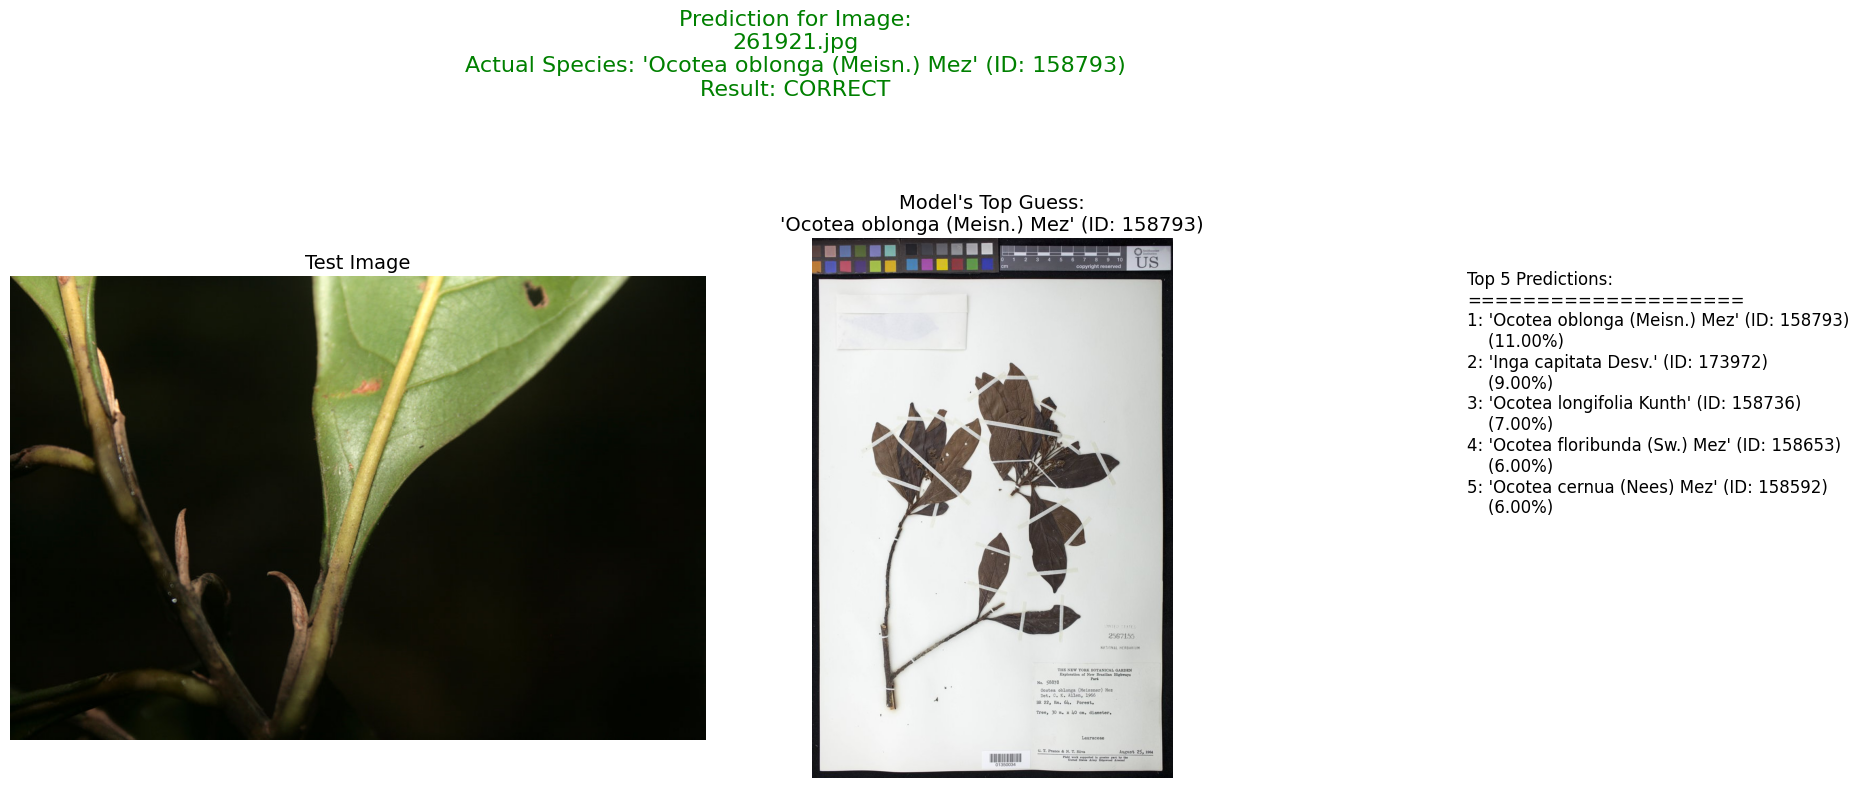


Processing image 34: 11534.jpg


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


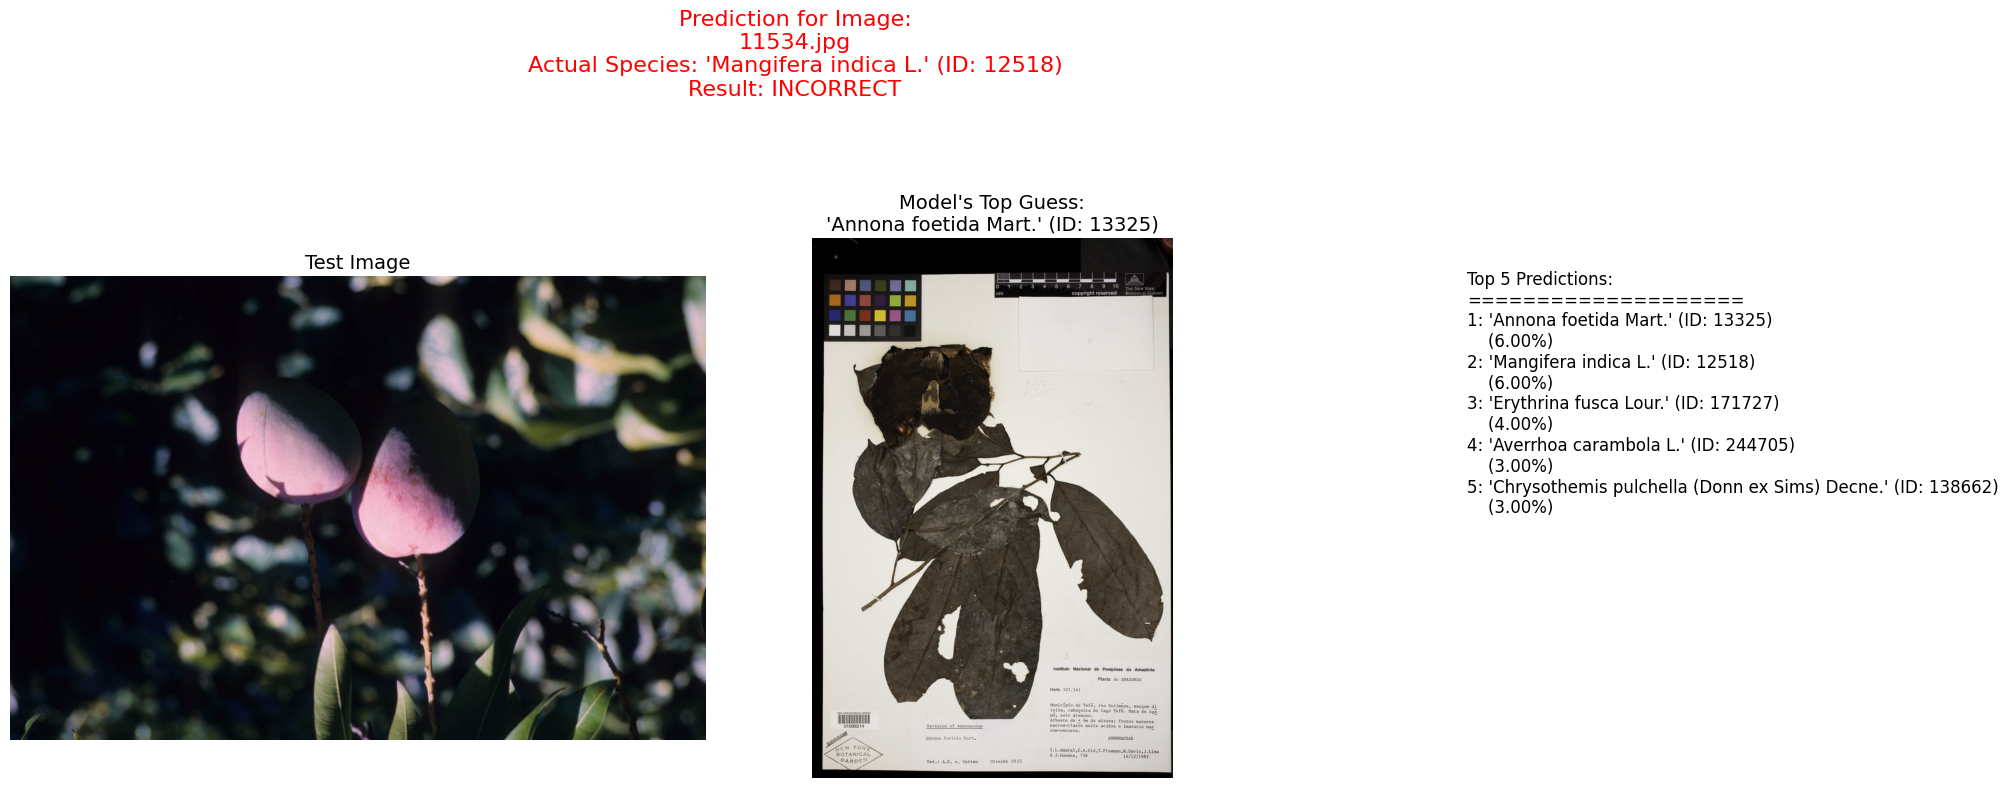


Processing image 139: 216090.jpg


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


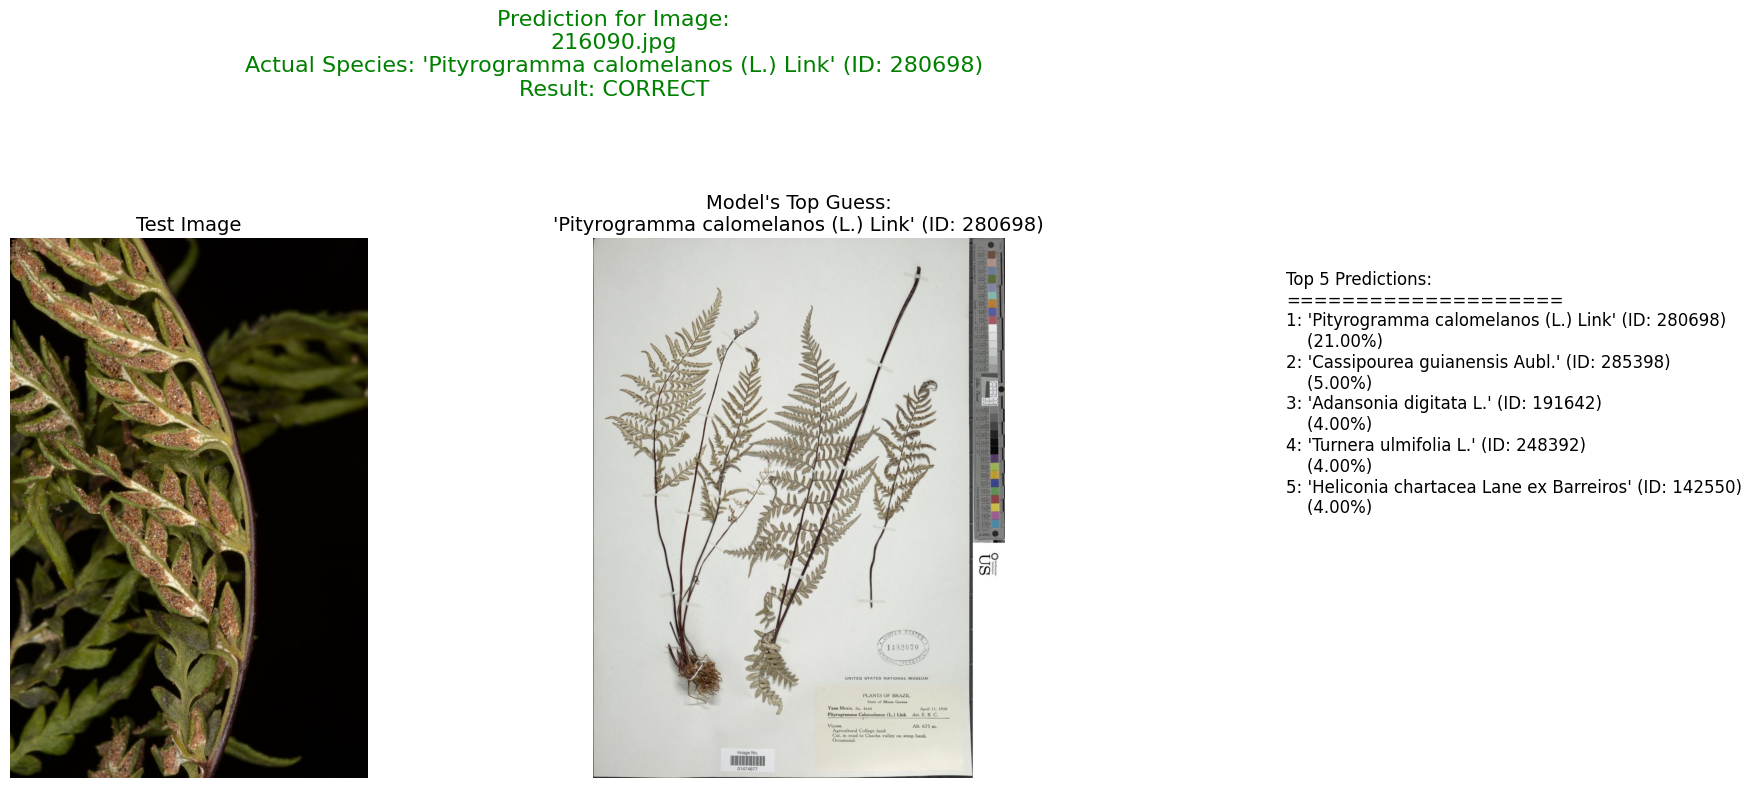

In [ ]:
# --- 4. Run Predictions and Visualize ---

print("--- Step 2: Generating and Visualizing Predictions for 3 Random Test Images ---")
# Select 3 random indices from the test set
random_indices = random.sample(range(len(test_image_paths)), 3)

for idx in random_indices:
    image_to_test_path = test_image_paths[idx]
    true_label = test_labels[idx]

    print(f"\nProcessing image {idx}: {os.path.basename(image_to_test_path)}")

    # Get a fresh prediction directly from the models
    top5_ids, top5_probabilities = predict_single_image(
        image_path=image_to_test_path,
        dinov2_model=dinov2_model,
        rf_classifier=rf_classifier,
        transform=transform, # 'transform' should be available from Cell 6
        device=device
    )

    # Visualize the result
    visualize_single_prediction(
        image_path=image_to_test_path,
        true_label_id=true_label,
        top5_pred_ids=top5_ids,
        top5_probs=top5_probabilities,
        species_map=species_id_to_name,
        train_paths=train_image_paths,
        train_labels=train_labels
    )